<a href="https://colab.research.google.com/github/37743/NTAI-Project/blob/main/Arabic_Handwriting_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

yousefgomaa43_arabic_ocr_project_dataset_path = kagglehub.dataset_download('yousefgomaa43/arabic-ocr-project-dataset')
yousefgomaa43_arabic_fonts_path = kagglehub.dataset_download('yousefgomaa43/arabic-fonts')

print('Data source import complete.')

Using Colab cache for faster access to the 'arabic-ocr-project-dataset' dataset.
Data source import complete.


In [ ]:
import shutil
import os

def copy_kaggle_input_to_drive(source_dir='/kaggle/', destination_dir='/content/drive/My Drive/arabic-backup/kaggle'):
    os.makedirs(destination_dir, exist_ok=True)
    try:
        shutil.copytree(source_dir, destination_dir, dirs_exist_ok=True)
        print(f"Contents of {source_dir} copied to {destination_dir}")
    except Exception as e:
        print(f"Error copying directory: {e}")

# NTAI - Arabic Handwriting Generation Project

ID: 320210207

Dataset was initialized using another kaggle notebook, some pre-processing is continued on this one.

## TODO:
- Use arabic handwritten text transformer to recognize fragments of the paragraph and compare them with ground truth.
- Train CVAE/CGAN/transformer on fragments of text + label

In [ ]:
%%capture

!pip install -qqq -U peft transformers bitsandbytes trl accelerate safetensors --no-cache-dir;

In [ ]:
# import shutil
# from pathlib import Path

# working_dir = Path("/kaggle/working")

# if not working_dir.exists():
#     print(f"{working_dir} does not exist.")
# else:
#     for child in working_dir.iterdir():
#         try:
#             if child.is_dir():
#                 shutil.rmtree(child)
#                 print(f"Removed directory: {child}")
#             else:
#                 child.unlink()
#                 print(f"Removed file: {child}")
#         except Exception as e:
#             print(f"Failed to remove {child}: {e}")

In [ ]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import json
import time

In [ ]:
df = pd.read_csv("/kaggle/input/arabic-ocr-project-dataset/labels/paragraph_labels_cleaned.csv")

df.head(10)

,image_path,paragraph_number,confidence,method,text
0,/kaggle/input/arabic-ocr-project-dataset/imgs_...,1.0,1.000,manual,تعد الهندسة البرمجية مجالا يجمع بين العلم والف...
1,/kaggle/input/arabic-ocr-project-dataset/imgs_...,10.0,1.000,manual,تلعب تقنيات الحوسبة السحابية دورا مهما في تطوي...
2,/kaggle/input/arabic-ocr-project-dataset/imgs_...,11.0,1.000,topband/bin,الذكاء الاصطناعي اصبح جزءا ال يتجزأ من الهندسة...
3,/kaggle/input/arabic-ocr-project-dataset/imgs_...,12.0,1.000,topband/gray,تطوير البرمجيات مفتوحة المصدر يسهم في خلق بيئة...
4,/kaggle/input/arabic-ocr-project-dataset/imgs_...,13.0,0.998,topband/bin,الواجهات البرمجية تسهل التكامل بين الانظمة الم...
5,/kaggle/input/arabic-ocr-project-dataset/imgs_...,14.0,0.999,topband/bin,البرمجة الشيئية تعد من اكثر الانماط استخداما ف...
6,/kaggle/input/arabic-ocr-project-dataset/imgs_...,15.0,0.880,topband/gray,في عالم تطوير البرمجيات تعد ادارة البيانات من ...
7,/kaggle/input/arabic-ocr-project-dataset/imgs_...,16.0,1.000,topband/gray,تطوير تطبيقات الويب يتطلب استخدام تقنيات متقدم...
8,/kaggle/input/arabic-ocr-project-dataset/imgs_...,17.0,0.995,topband/gray,في مجال تطوير تطبيقات الهواتف الذكية يعتمد الم...
9,/kaggle/input/arabic-ocr-project-dataset/imgs_...,18.0,1.000,topband/gray,برمجيات انترنت الاشياء اصبحت من اكثر المجالات ...


In [ ]:
# df['image_path'] = df['image_path'].apply(lambda x: x.replace('/content/Arabic_OCR_Dataset', '/kaggle/input/arabic-ocr-project-dataset'))

json_path = '/kaggle/input/arabic-ocr-project-dataset/labels/arabic_paragraphs_all.json'
with open(json_path, 'r', encoding='utf-8') as f:
    paragraphs = json.load(f)

paragraph_df = pd.DataFrame(paragraphs)

# df = df.merge(paragraph_df[['paragraph_number', 'text']], on='paragraph_number', how='left')

# df.head(10)

In [ ]:
print(df[['image_path', 'confidence']].sort_values(by='confidence', ascending=True))

                                            image_path  confidence
620  /kaggle/input/arabic-ocr-project-dataset/imgs_...       0.800
51   /kaggle/input/arabic-ocr-project-dataset/imgs_...       0.806
203  /kaggle/input/arabic-ocr-project-dataset/imgs_...       0.811
364  /kaggle/input/arabic-ocr-project-dataset/imgs_...       0.812
274  /kaggle/input/arabic-ocr-project-dataset/imgs_...       0.814
..                                                 ...         ...
651  /kaggle/input/arabic-ocr-project-dataset/imgs_...       1.000
652  /kaggle/input/arabic-ocr-project-dataset/imgs_...       1.000
653  /kaggle/input/arabic-ocr-project-dataset/imgs_...       1.000
654  /kaggle/input/arabic-ocr-project-dataset/imgs_...       1.000
0    /kaggle/input/arabic-ocr-project-dataset/imgs_...       1.000

[655 rows x 2 columns]


In [ ]:
# for index, row in df.iterrows():
#     if row['confidence'] < 0.8 or row['paragraph_number'] == 0:
#         image_path = row['image_path']
#         print(f"Processing image: {image_path}")

#         try:
#             clear_output(wait=True) # Clear the output before showing the next image
#             img = mpimg.imread(image_path)
#             plt.figure(figsize=(10, 10)) # Adjust figure size as needed
#             plt.imshow(img)
#             plt.axis('off')  # Hide axes
#             plt.show()

#             time.sleep(2) # Add a 2-second delay

#             while True:
#                 try:
#                     new_paragraph_number_input = input(f"Enter new paragraph number for {image_path} (current: {row['paragraph_number']}) or type 'skip' to skip: ")
#                     if new_paragraph_number_input.lower() == 'skip':
#                         df.at[index, 'confidence'] = 1.0
#                         print(f"Skipped updating paragraph number for {image_path}. Confidence set to 1.0.")
#                         break
#                     else:
#                         new_paragraph_number = int(new_paragraph_number_input)
#                         # Check if the entered paragraph number exists in the original paragraphs data
#                         if new_paragraph_number in paragraph_df['paragraph_number'].values:
#                             df.at[index, 'paragraph_number'] = new_paragraph_number
#                             df.at[index, 'confidence'] = 1.0
#                             df.at[index, 'method'] = 'manual'
#                             print(f"Updated {image_path} with new paragraph number: {new_paragraph_number}")
#                             break # Exit the inner loop if input is valid
#                         else:
#                             print("Invalid paragraph number. Please enter a number that exists in the original paragraph list or 'skip'.")
#                 except ValueError:
#                     print("Invalid input. Please enter an integer for the paragraph number or 'skip'.")

#         except FileNotFoundError:
#             print(f"Error: Image file not found at {image_path}")
#         except Exception as e:
#             print(f"An error occurred while processing {image_path}: {e}")

# print("Finished processing images with confidence less than 0.8.")

In [ ]:
import shutil
import os

source_dir = '/kaggle/input/arabic-ocr-project-dataset'
destination_dir = '/kaggle/working/arabic-ocr-project-dataset_copy'

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Copy the contents of the source directory to the destination directory
try:
    shutil.copytree(source_dir, destination_dir, dirs_exist_ok=True)
    print(f"Dataset copied from {source_dir} to {destination_dir}")
except Exception as e:
    print(f"Error copying dataset: {e}")

Dataset copied from /kaggle/input/arabic-ocr-project-dataset to /kaggle/working/arabic-ocr-project-dataset_copy


In [ ]:
df.to_csv("/kaggle/working/arabic-ocr-project-dataset_copy/labels/paragraph_labels_cleaned.csv", index=False)
print("DataFrame saved successfully.")

DataFrame saved successfully.


In [ ]:
!pip -q install kaggle

from google.colab import files
uploaded = files.upload()  # pick kaggle.json

import os, json, shutil, pathlib
pathlib.Path('/root/.kaggle').mkdir(parents=True, exist_ok=True)
shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')
os.chmod('/root/.kaggle/kaggle.json', 0o600)

with open('/root/.kaggle/kaggle.json') as f:
    token = json.load(f)
print("Kaggle username:", token.get("username"))


Saving kaggle.json to kaggle.json
Kaggle username: yousefgomaa43


In [ ]:
from pathlib import Path

DATA_DIR = Path("/kaggle/working/arabic-ocr-project-dataset_copy")

DATASET_SLUG = "arabic-ocr-project-dataset"
DATASET_TITLE = "Arabic OCR Project Dataset"
OWNER_USERNAME = "yousefgomaa43"

metadata_path = DATA_DIR / "dataset-metadata.json"
if not metadata_path.exists():
    with open(metadata_path, "w", encoding="utf-8") as f:
        f.write(f'''{{
  "title": "{DATASET_TITLE}",
  "id": "{OWNER_USERNAME}/{DATASET_SLUG}",
  "licenses": [{{"name": "CC0-1.0"}}]
}}''')
    print("✅ Created dataset-metadata.json")
else:
    print("✅ dataset-metadata.json already exists")

!kaggle datasets version -p "$DATA_DIR" -m "Updated paragraph labels, now fully cleaned" -q -r zip

print("✅ Dataset folders reorganized and new version uploaded successfully.")

✅ Created dataset-metadata.json
Dataset version is being created. Please check progress at https://www.kaggle.com/datasets/yousefgomaa43/arabic-ocr-project-dataset
✅ Dataset folders reorganized and new version uploaded successfully.


In [ ]:
print(df.paragraph_number.value_counts().sum(),'\n\n\n', df.paragraph_number.value_counts())

655 


 paragraph_number
2.0      31
5.0      24
6.0      23
9.0      22
3.0      21
         ..
206.0     1
136.0     1
182.0     1
208.0     1
88.0      1
Name: count, Length: 190, dtype: int64


In [ ]:
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from io import BytesIO
import glob
from pathlib import Path
import numpy as np

In [201]:
def _area(x, y, w, h):
    return max(0, w) * max(0, h)

def _intersect(a, b):
    ax, ay, aw, ah = a
    bx, by, bw, bh = b
    ax1, ay1 = ax + aw, ay + ah
    bx1, by1 = bx + bw, by + bh
    ix0, iy0 = max(ax, bx), max(ay, by)
    ix1, iy1 = min(ax1, bx1), min(ay1, by1)
    iw, ih = max(0, ix1 - ix0), max(0, iy1 - iy0)
    return ix0, iy0, iw, ih

def _union(a, b):
    ax, ay, aw, ah = a
    bx, by, bw, bh = b
    x0, y0 = min(ax, bx), min(ay, by)
    x1, y1 = max(ax + aw, bx + bw), max(ay + ah, by + bh)
    return (x0, y0, x1 - x0, y1 - y0)

def merge_bounding_boxes(
    boxes,
    min_overlap_ratio=0.25,
    wide_aspect_threshold=6.0,
    thin_height_frac=0.15,
    max_iters=64
):
    if not boxes:
        return []
    boxes = [tuple(map(int, b)) for b in boxes]

    for _ in range(max_iters):
        n = len(boxes)
        used = [False] * n
        out = []
        changed = False

        for i in range(n):
            if used[i]:
                continue
            acc = boxes[i]
            ax, ay, aw, ah = acc
            for j in range(i + 1, n):
                if used[j]:
                    continue
                bj = boxes[j]
                bx, by, bw, bh = bj

                _, _, iw, ih = _intersect(acc, bj)
                if iw == 0 or ih == 0:
                    continue

                # skip if intersection is a wide horizontal strip (vertically stacked boxes)
                is_wide = (iw / float(ih)) >= wide_aspect_threshold
                is_thin_vs_boxes = ih <= thin_height_frac * min(ah, bh)
                if is_wide or is_thin_vs_boxes:
                    continue

                inter = iw * ih
                a_area = _area(*acc)
                b_area = _area(*bj)
                min_area = min(a_area, b_area)
                if min_area == 0:
                    continue

                if inter >= min_overlap_ratio * min_area:
                    acc = _union(acc, bj)
                    ax, ay, aw, ah = acc
                    used[j] = True
                    changed = True

            used[i] = True
            out.append(acc)

        boxes = out
        if not changed:
            break

    return sorted(boxes, key=lambda b: (b[1], b[0]))

def add_padding_to_bounding_boxes(boxes, padding_x=10, padding_y=8, W=None, H=None):
    padded_boxes = []
    for (x, y, w, h) in boxes:
        x0 = max(x - padding_x, 0)
        y0 = max(y - padding_y, 0)
        x1 = x + w + padding_x
        y1 = y + h + padding_y
        if W is not None: x1 = min(x1, W)
        if H is not None: y1 = min(y1, H)
        padded_boxes.append((x0, y0, x1 - x0, y1 - y0))
    return padded_boxes

# ---- Helpers ----
def _resize_keep_ar(img, target_h):
    h, w = img.shape[:2]
    if h == 0 or w == 0:
        return img
    scale = target_h / float(h)
    w_new = max(1, int(round(w * scale)))
    return cv2.resize(img, (w_new, target_h), interpolation=cv2.INTER_LINEAR)

def _pick_bucket(width, buckets):
    for b in buckets:
        if width <= b: return b
    return buckets[-1]

def _pad_left(canvas_h, canvas_w, crop):
    h, w = crop.shape[:2]
    cw = max(canvas_w, w)
    if crop.ndim == 2:
        canvas = np.full((canvas_h, cw), 255, dtype=crop.dtype)
    else:
        canvas = np.full((canvas_h, cw, crop.shape[2]), 255, dtype=crop.dtype)
    x0 = cw - w
    canvas[0:h, x0:x0+w] = crop
    return canvas

def crop_handwriting_with_subplots(
    image_path,
    out_dir,
    top_exclude_ratio=0.05,
    bottom_exclude_ratio=0.15,
    side_margin_ratio=0.01,
    blackhat_kernel=(15, 15),
    line_h_len_ratio=0.15,
    line_v_len_ratio=0.15,
    close_kernel=(25, 2),
    merge_kernel=(35, 3),
    min_cc_area=400,
    save_union=False,
    save_crop=False,
    visualize=False,
    consistent_size=(512, 512),
    # Arabic crop options
    crop_target_height=128,
    crop_width_buckets=(128, 192, 256, 384, 512, 768, 1024),
    crop_prefix="",
    rtl_sort_within_line=True,
    line_merge_vertical_gap=0.25,
    preprocess_target_size=(3000, 2000)
):
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    img = cv2.imread(str(image_path))
    if img is None:
        raise FileNotFoundError(image_path)

    target_h, target_w = preprocess_target_size
    img = cv2.resize(img, (target_w, target_h), interpolation=cv2.INTER_AREA)
    H_full, W_full = img.shape[:2]

    # Cut margins
    y_top_cut = int(H_full * top_exclude_ratio)
    y_bottom_cut = int(H_full * (1 - bottom_exclude_ratio))
    x_left_cut = int(W_full * side_margin_ratio)
    x_right_cut = int(W_full * (1 - side_margin_ratio))
    img_cropped = img[y_top_cut:y_bottom_cut, x_left_cut:x_right_cut]
    Hc, Wc = img_cropped.shape[:2]

    gray_full = cv2.cvtColor(img_cropped, cv2.COLOR_BGR2GRAY)

    # Remove horizontal lines (inpaint)
    thresh = cv2.adaptiveThreshold(gray_full, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                   cv2.THRESH_BINARY_INV, 81, 17)
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 1))
    remove_horizontal = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=3)
    cnts = cv2.findContours(remove_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    mask_lines = np.zeros(gray_full.shape, np.uint8)
    for c in cnts:
        cv2.drawContours(mask_lines, [c], -1, (255, 255, 255), 6)
    img_clean = cv2.inpaint(img_cropped, mask_lines, 3, cv2.INPAINT_TELEA)

    gray = cv2.cvtColor(img_clean, cv2.COLOR_BGR2GRAY)

    # Blackhat + binarize
    bh = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT,
                          cv2.getStructuringElement(cv2.MORPH_RECT, blackhat_kernel))
    _, bw = cv2.threshold(bh, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Remove long horizontal/vertical lines
    hlen = max(35, int(Wc * line_h_len_ratio))
    vlen = max(35, int(Hc * line_v_len_ratio))
    h_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (hlen, 3))
    v_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, vlen))
    lines_h = cv2.morphologyEx(bw, cv2.MORPH_OPEN, h_kernel)
    lines_v = cv2.morphologyEx(bw, cv2.MORPH_OPEN, v_kernel)
    lines = cv2.bitwise_or(lines_h, lines_v)
    mask = cv2.bitwise_and(bw, cv2.bitwise_not(lines))

    # Close, CC filter
    closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE,
                              cv2.getStructuringElement(cv2.MORPH_RECT, close_kernel), iterations=2)

    num, lab, stats, _ = cv2.connectedComponentsWithStats(closed, connectivity=8)
    keep = np.zeros_like(closed)
    for i in range(1, num):
        x, y, w, h, area = stats[i]
        if area >= min_cc_area:
            keep[lab == i] = 255

    merged = cv2.dilate(keep, cv2.getStructuringElement(cv2.MORPH_RECT, merge_kernel), iterations=1)

    # Extract boxes (in cropped coords)
    boxes = []
    num_boxes, lab_boxes, stats_boxes, _ = cv2.connectedComponentsWithStats(merged, connectivity=8)
    for i in range(1, num_boxes):
        x, y, w, h, area = stats_boxes[i]
        if area >= min_cc_area:
            if h / max(1, w) > 1.1:  # skip very-vertical blobs
                continue
            boxes.append((int(x), int(y), int(w), int(h)))

    boxes = add_padding_to_bounding_boxes(boxes, padding_x=15, padding_y=10, W=Wc, H=Hc)
    boxes = merge_bounding_boxes(boxes)

    # Sort top->bottom; within each line right->left (Arabic)
    if boxes:
        median_h = np.median([h for (_, _, _, h) in boxes])
        y_tol = max(5, int(median_h * line_merge_vertical_gap))
        boxes_sorted = sorted(boxes, key=lambda b: (b[1], b[0]))
        lines = []
        current_line = [boxes_sorted[0]]
        for b in boxes_sorted[1:]:
            if abs(b[1] - current_line[-1][1]) <= y_tol:
                current_line.append(b)
            else:
                current_line = sorted(current_line, key=lambda t: t[0], reverse=rtl_sort_within_line)
                lines.append(current_line)
                current_line = [b]
        current_line = sorted(current_line, key=lambda t: t[0], reverse=rtl_sort_within_line)
        lines.append(current_line)
        boxes = [b for line in lines for b in line]

    saved_crops = []
    if save_crop and boxes:
        for idx, (x, y, w, h) in enumerate(boxes, start=1):
            crop = img_cropped[y:y+h, x:x+w]

            crop_resized = _resize_keep_ar(crop, crop_target_height)

            gray_crop = cv2.cvtColor(crop_resized, cv2.COLOR_BGR2GRAY)
            _, crop_bin = cv2.threshold(gray_crop, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

            h2, w2 = crop_bin.shape[:2]
            bucket_w = _pick_bucket(w2, crop_width_buckets)
            if w2 > bucket_w:
                crop_bin = cv2.resize(crop_bin, (bucket_w, h2), interpolation=cv2.INTER_AREA)
                w2 = bucket_w
            canvas_bin = _pad_left(h2, bucket_w, crop_bin)

            canvas_bin = (canvas_bin > 127).astype(np.uint8) * 255
            out_path = out_dir / f"{crop_prefix}{idx}.png"
            cv2.imwrite(str(out_path), canvas_bin)
            saved_crops.append(str(out_path))

    union_resized = None
    union_path = None
    if boxes:
        xs = [x for x, _, _, _ in boxes]
        ys = [y for _, y, _, _ in boxes]
        xe = [x + w for x, _, w, _ in boxes]
        ye = [y + h for _, y, _, h in boxes]
        x0 = max(min(xs) - 10, 0)
        y0 = max(min(ys) - 10, 0)
        x1 = min(max(xe) + 10, Wc)
        y1 = min(max(ye) + 10, Hc)
        union = img_cropped[y0:y1, x0:x1]
        union_resized = cv2.resize(union, tuple(consistent_size), interpolation=cv2.INTER_LINEAR)
        if save_union:
            union_path = out_dir / "union_crop_resized.png"
            cv2.imwrite(str(union_path), union_resized)

    if visualize:
        fig, axs = plt.subplots(3, 3, figsize=(15, 15))
        axs = axs.ravel()
        stages = [
            ("Original (normalized 2000x3000)", img),
            ("Cropped ROI", img_cropped),
            ("Gray", gray),
            ("Black-hat", bh),
            ("Binary", bw),
            ("No Lines", mask),
            ("Closed", closed),
            ("Merged", merged)
        ]
        for i, (title, im) in enumerate(stages):
            if i >= len(axs): break
            axs[i].imshow(im if im.ndim == 2 else cv2.cvtColor(im, cv2.COLOR_BGR2RGB), cmap="gray")
            axs[i].set_title(title)
            axs[i].axis("off")

        vis = img_cropped.copy()
        for (x, y, w, h) in boxes:
            cv2.rectangle(vis, (x, y), (x + w, y + h), (0, 255, 0), 3)
        axs[-1].imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
        axs[-1].set_title("Detected boxes (RTL sorted)")
        axs[-1].axis("off")
        plt.tight_layout()
        plt.show()

    return union_resized, boxes, (str(union_path) if union_path is not None else None), saved_crops

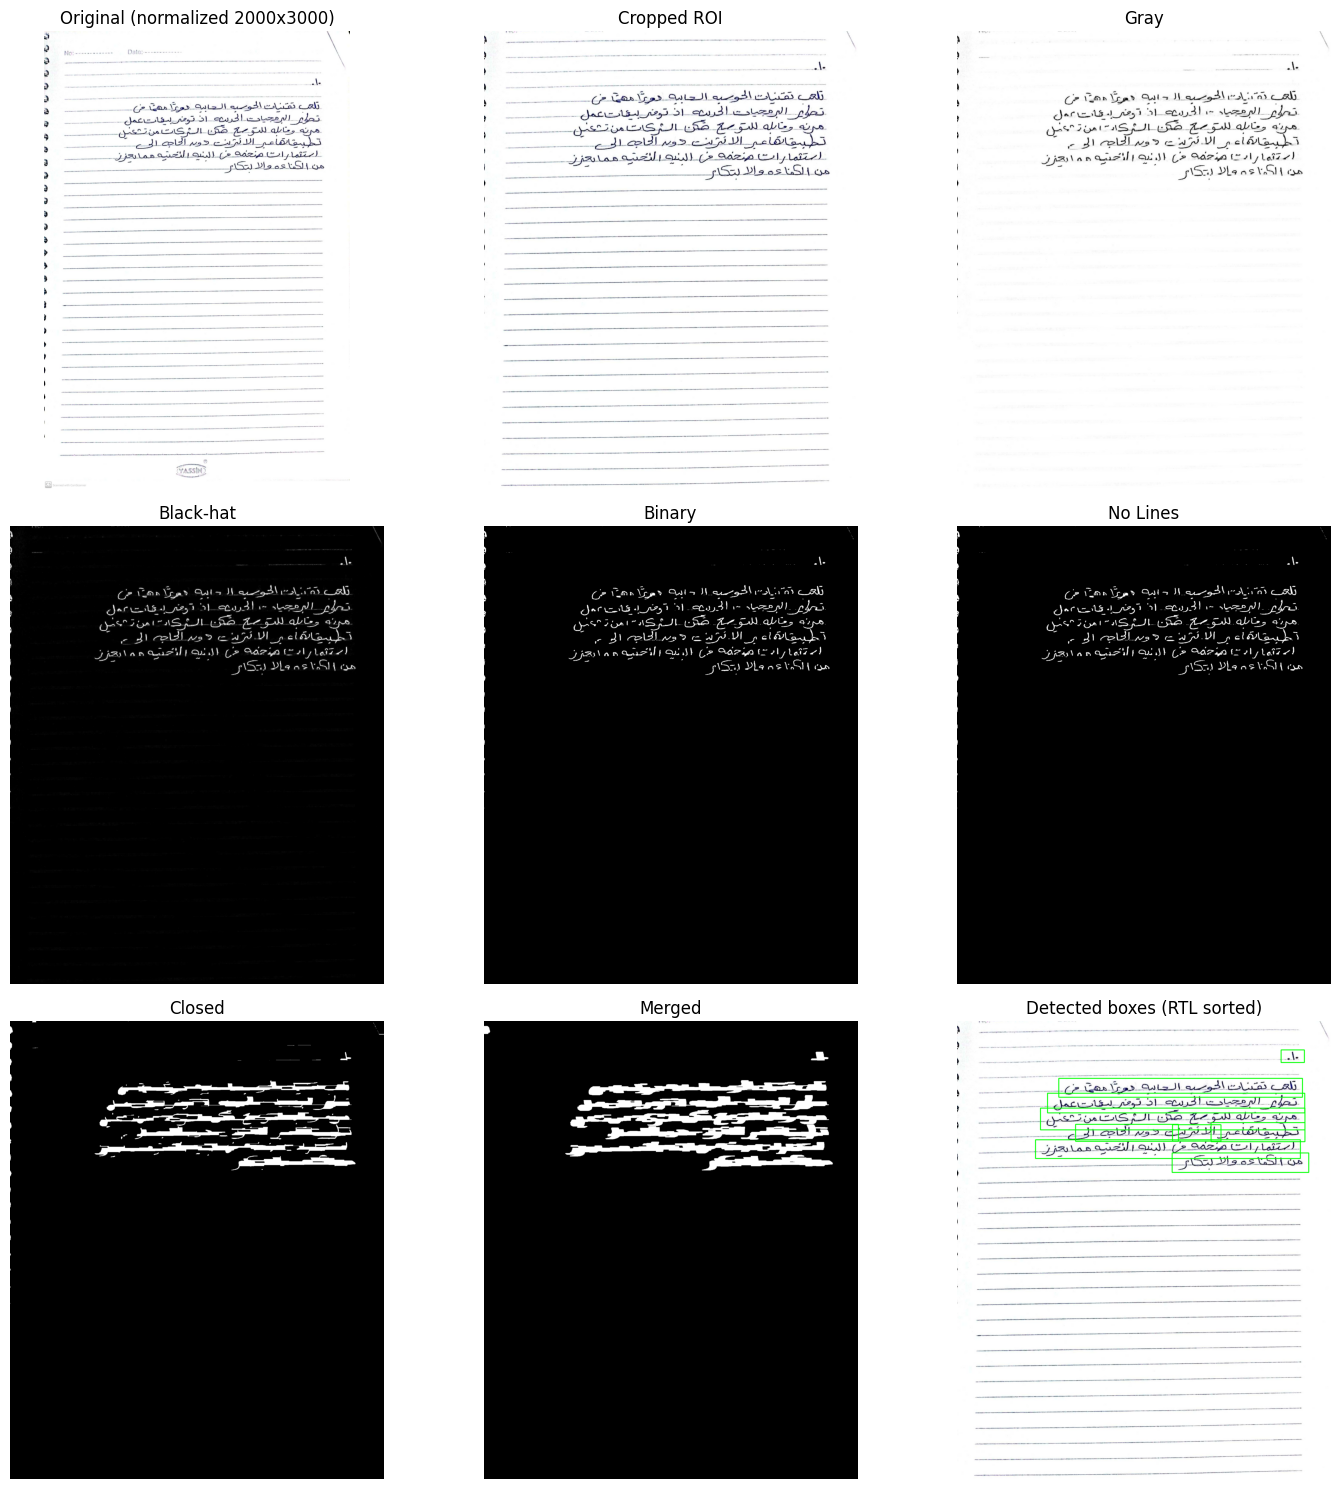

In [205]:
img_path = "/kaggle/input/arabic-ocr-project-dataset/imgs_scans/Image 448.jpg"
union, boxes, _, crops = crop_handwriting_with_subplots(img_path, out_dir="/kaggle/test/"+"10", save_crop=True, visualize=True)

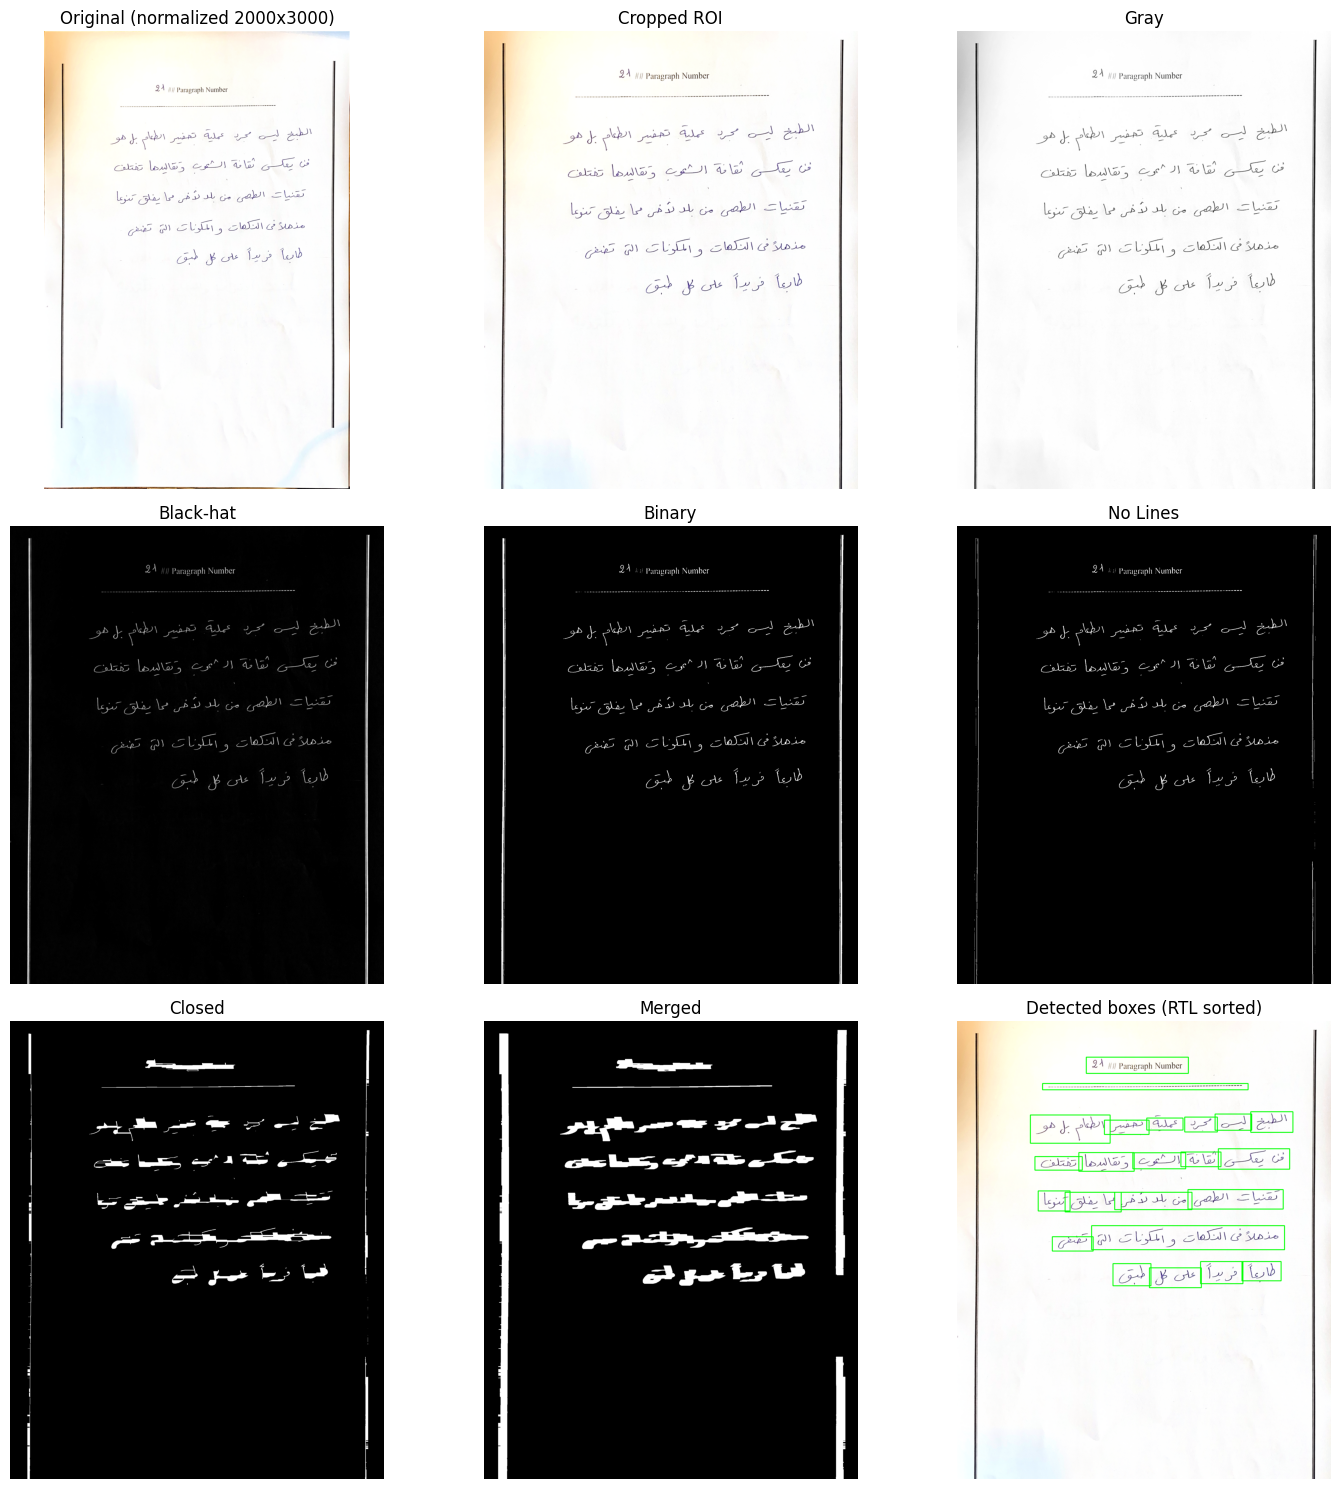

In [203]:
img_path = "/kaggle/input/arabic-ocr-project-dataset/imgs_scans/Image 52.png"
union, boxes, _, crops = crop_handwriting_with_subplots(img_path, out_dir="/kaggle/test/"+"21", save_crop=True, visualize=True)

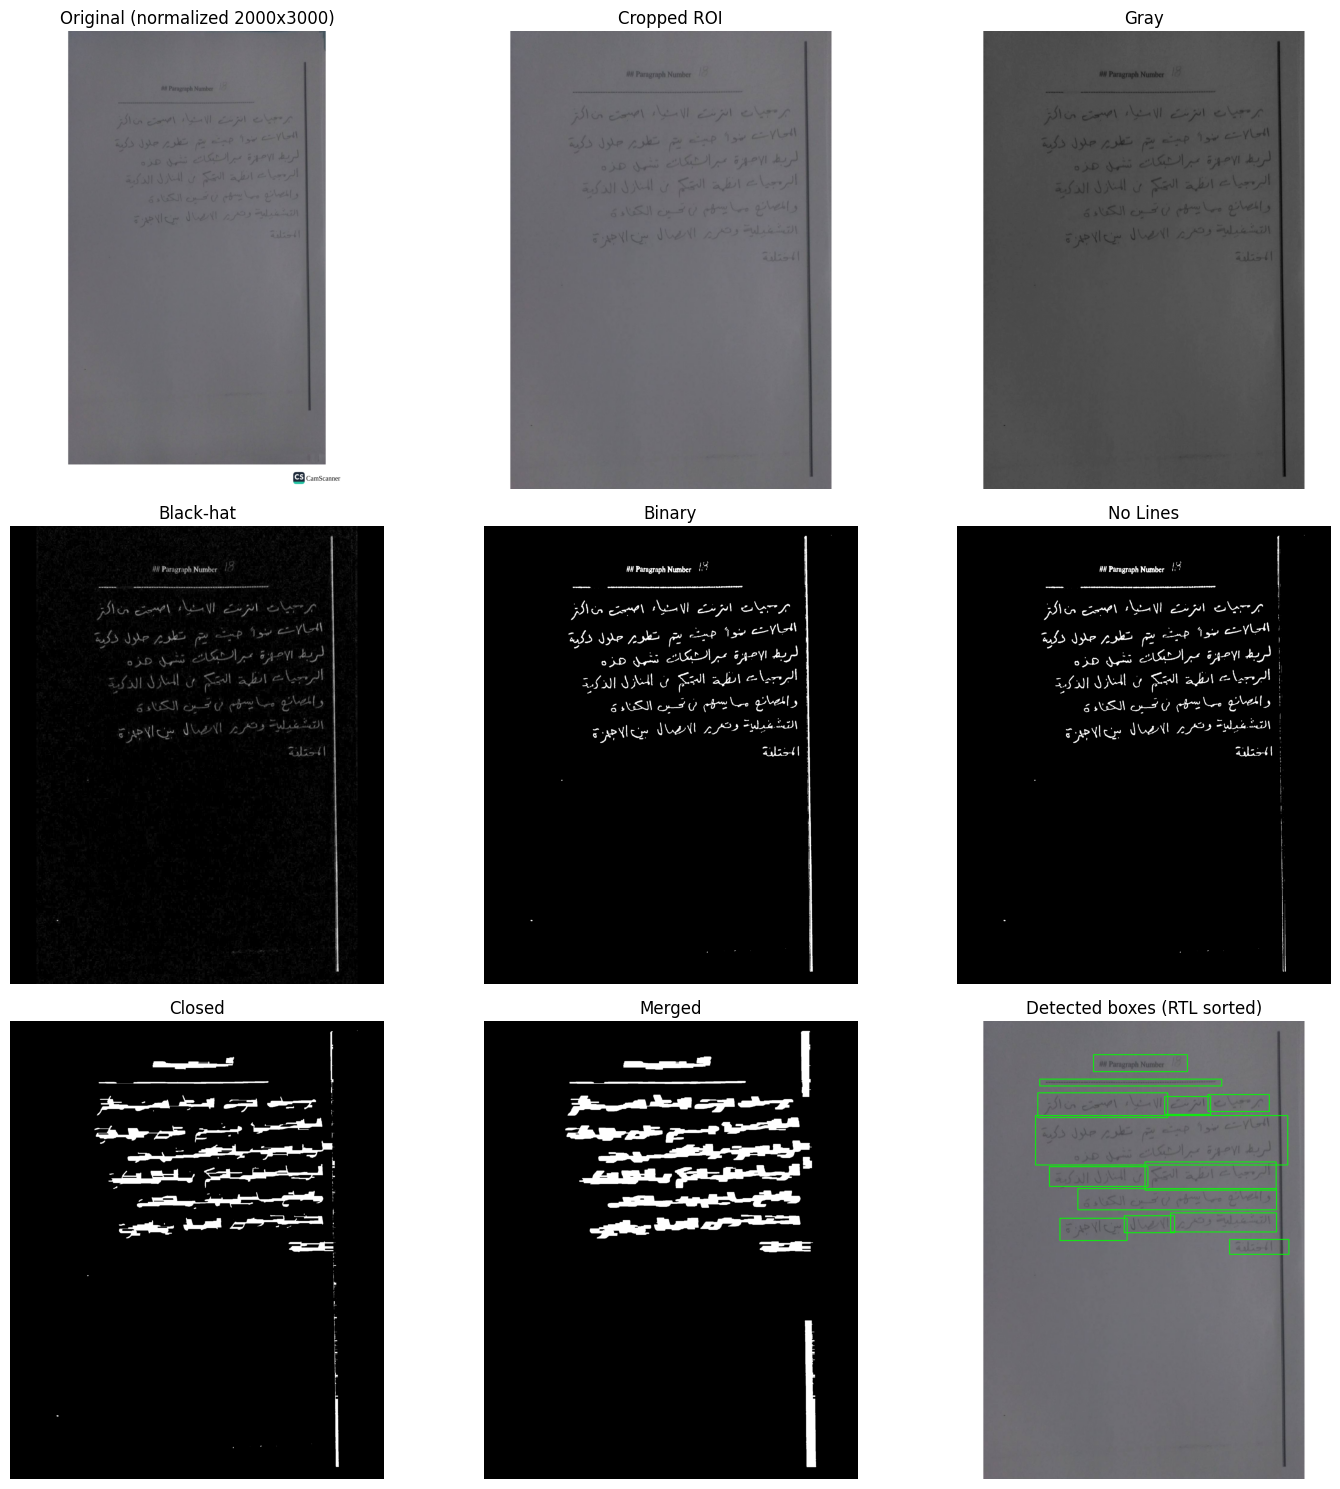

In [191]:
img_path = "/kaggle/input/arabic-ocr-project-dataset/imgs_scans/Image 209.png"
union, boxes, _, crops = crop_handwriting_with_subplots(img_path, out_dir="/kaggle/test/"+"18", visualize=True)

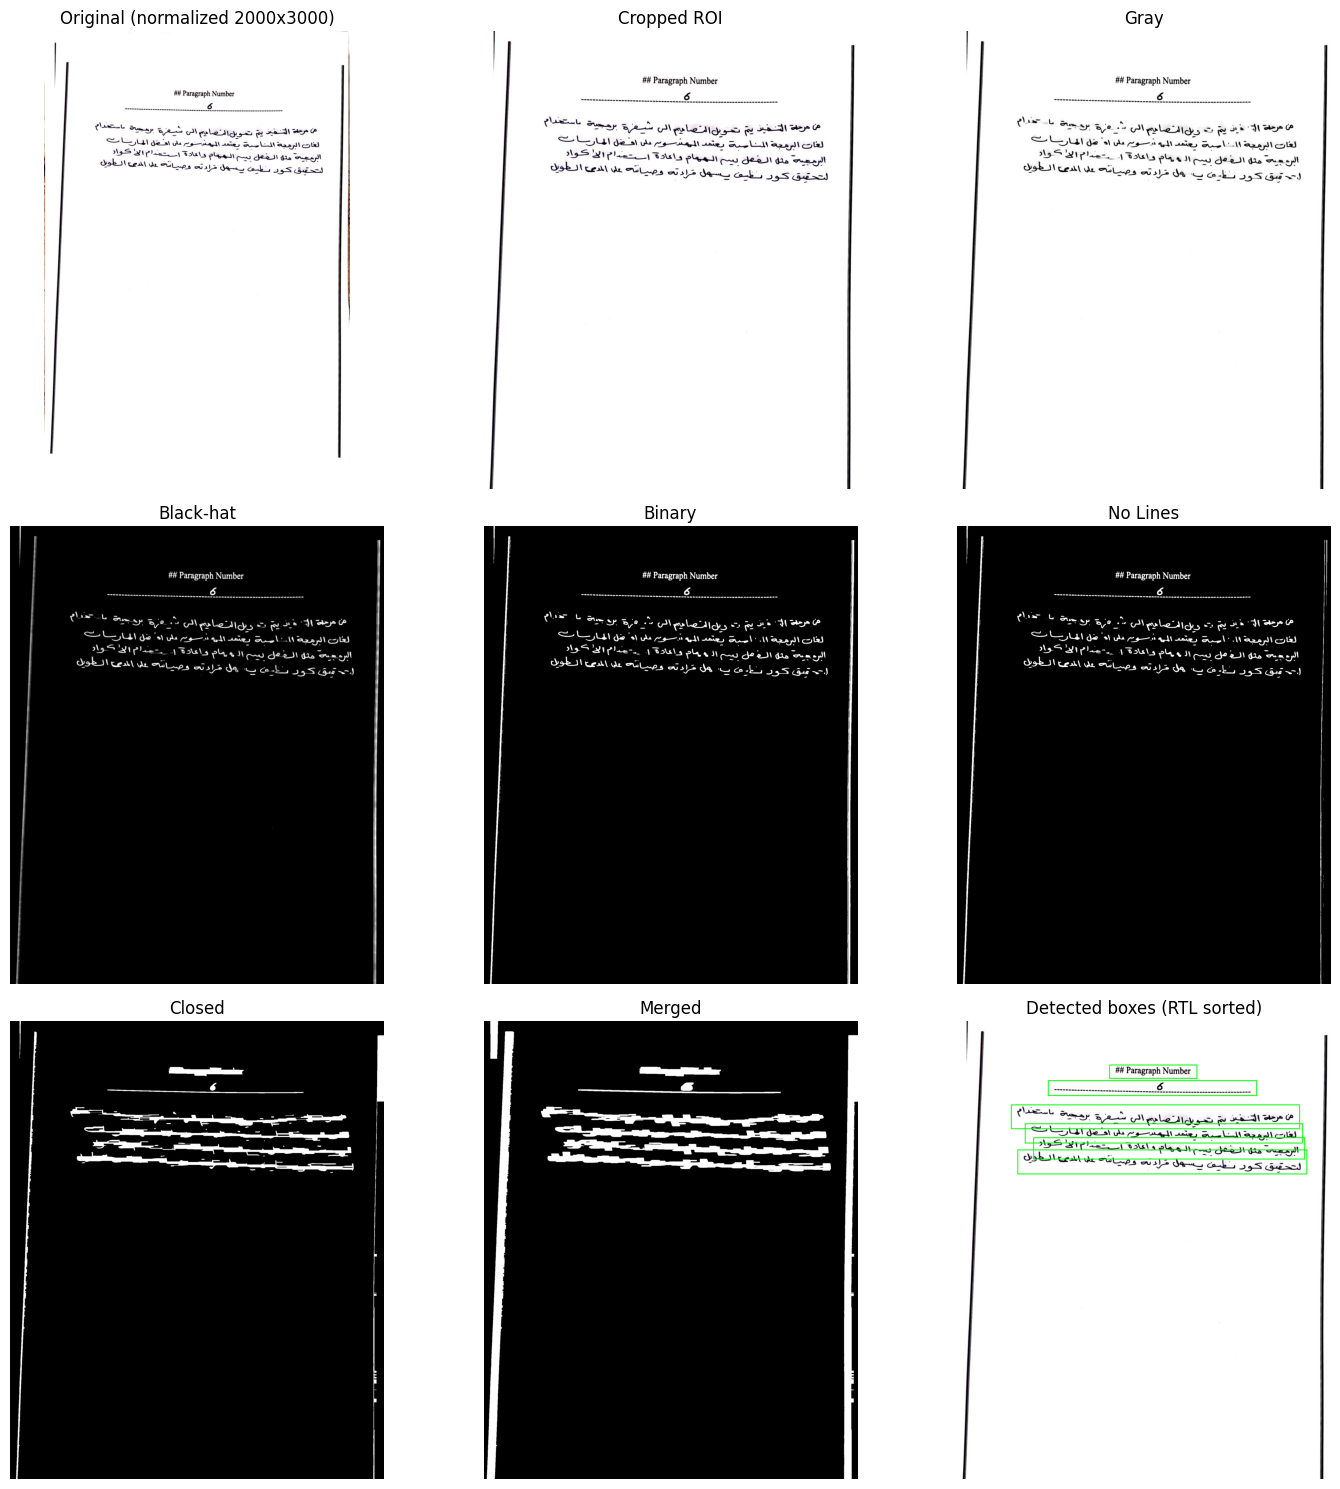

In [199]:
img_path = "/kaggle/input/arabic-ocr-project-dataset/imgs_scans/Image 98.png"
union, boxes, _, crops = crop_handwriting_with_subplots(img_path, out_dir="/kaggle/test/"+"6", save_crop=True, visualize=True)

In [ ]:
for _, row in df.iterrows():
    image_path = row['image_path']
    paragraph_number = int(row['paragraph_number'])
    image_name = Path(image_path).stem
    out_dir = Path("/kaggle/test/") / str(paragraph_number) / image_name
    out_dir.mkdir(parents=True, exist_ok=True)

    sentence_images, detected_boxes, union_path = crop_handwriting_with_subplots(
        image_path,
        out_dir,
        save_union=True,
        save_crop=False,
        visualize=False,
        consistent_size=(512, 512)
    )

print("Done!")

In [ ]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
import torch
from PIL import Image
from typing import List, Dict

def process_vision_info(messages: List[dict]):
    image_inputs = []
    video_inputs = []
    for message in messages:
        if isinstance(message["content"], list):
            for item in message["content"]:
                if item["type"] == "image":
                    image = item["image"]
                    if isinstance(image, str):
                        image = Image.open(image).convert("RGB")
                    elif isinstance(image, Image.Image):
                        pass
                    else:
                        raise ValueError(f"Unsupported image type: {type(image)}")
                    image_inputs.append(image)
                elif item["type"] == "video":
                    video_inputs.append(item["video"])
    return image_inputs if image_inputs else None, video_inputs if video_inputs else None

# Load model and processor
model_name = "sherif1313/Arabic-handwritten-OCR-4bit-Qwen2.5-VL-3B-v1"
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)

# Setup processor
min_pixels = 512 * 28 * 28
max_pixels = 2048 * 28 * 28
processor = AutoProcessor.from_pretrained(
    model_name,
    min_pixels=min_pixels,
    max_pixels=max_pixels
)

def extract_text_from_image(image_path):
    try:
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": image_path},
                    {"type": "text", "text": "Read all texts in this image and extract them as they are. Don't miss any word."},
                ],
            }
        ]

        text = processor.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )
        image_inputs, video_inputs = process_vision_info(messages)

        inputs = processor(
            text=[text],
            images=image_inputs,
            videos=video_inputs,
            padding=True,
            return_tensors="pt",
        ).to(model.device)

        generated_ids = model.generate(
            **inputs,
            max_new_tokens=1000,
            do_sample=False,
            pad_token_id=processor.tokenizer.pad_token_id
        )

        input_len = inputs.input_ids.shape[1]
        output_text = processor.batch_decode(
            generated_ids[:, input_len:],
            skip_special_tokens=True,
            clean_up_tokenization_spaces=False
        )[0]

        return output_text.strip()

    except Exception as e:
        return f"Error processing image: {e}"

`torch_dtype` is deprecated! Use `dtype` instead!
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/2.40G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

video_preprocessor_config.json:   0%|          | 0.00/913 [00:00<?, ?B/s]

In [209]:
image_path = "/kaggle/test/21/1.png"
extracted_text = extract_text_from_image(image_path)
print("Extracted Text:")
print(extracted_text)

Extracted Text:
21 ||| Paragraph Number


In [ ]:
import unicodedata
import re
from typing import Tuple, Optional

def strip_diacritics(s: str) -> str:
    # removes Arabic & Latin diacritics by stripping all combining marks
    nfkd = unicodedata.normalize("NFKD", s)
    return "".join(ch for ch in nfkd if not unicodedata.combining(ch))

def normalize_text(
    s: str,
    *,
    casefold: bool = True,
    rm_diacritics: bool = True,
    replace_newlines: bool = True
) -> str:
    """Normalize Unicode, optionally remove diacritics, lowercase, and collapse newlines to spaces."""
    if replace_newlines:
        s = re.sub(r"[\r\n]+", " ", s)
    if rm_diacritics:
        s = strip_diacritics(s)
    s = unicodedata.normalize("NFKC", s)
    return s.casefold() if casefold else s

WORD_RE = re.compile(r"\S+")

def words_with_spans(text: str):
    """Return [(word, start, end), ...] where spans point into the original text."""
    return [(m.group(), m.start(), m.end()) for m in WORD_RE.finditer(text)]

def levenshtein(a: str, b: str) -> int:
    """Simple DP edit distance on strings (O(len(a)*len(b)))."""
    if a == b:
        return 0
    if not a:
        return len(b)
    if not b:
        return len(a)
    if len(a) > len(b):
        a, b = b, a
    prev = list(range(len(b) + 1))
    for i, ca in enumerate(a, 1):
        cur = [i]
        for j, cb in enumerate(b, 1):
            ins = cur[j-1] + 1
            dele = prev[j] + 1
            sub = prev[j-1] + (ca != cb)
            cur.append(min(ins, dele, sub))
        prev = cur
    return prev[-1]

def find_closest_sequence(
    query_text: str,
    paragraph_text: str,
    *,
    casefold: bool = True,
    rm_diacritics: bool = True,
) -> Tuple[Optional[str], Optional[Tuple[int, int]], int]:
    """
    Returns:
      - matched_substring (exact slice from original paragraph) or None
      - (start, end) span in original paragraph, or None
      - edit_distance (int)
    """
    q_words = [w for w, _, _ in words_with_spans(query_text)]
    if not q_words:
        return None, None, 0
    win_len = len(q_words)

    p_words_spans = words_with_spans(paragraph_text)
    p_words = [w for w, _, _ in p_words_spans]

    q_norm = normalize_text(" ".join(q_words), casefold=casefold, rm_diacritics=rm_diacritics)

    best = (None, None, float("inf"))  # (span, matched_substring, distance)

    for i in range(0, max(0, len(p_words) - win_len + 1)):
        # window words + span in original text
        w_slice = p_words_spans[i:i+win_len]
        start, end = w_slice[0][1], w_slice[-1][2]
        candidate_raw = paragraph_text[start:end]

        # normalize window
        cand_norm = normalize_text(" ".join(w for w, _, _ in w_slice),
                                   casefold=casefold, rm_diacritics=rm_diacritics)
        dist = levenshtein(q_norm, cand_norm)

        if dist < best[2]:
            best = ((start, end), candidate_raw, dist)

            if dist == 0:
                break

    if best[0] is None:
        return None, None, 0
    return best[1], best[0], int(best[2])

def remove_span_neatly(text: str, span: Tuple[int, int]) -> str:
    """Remove [start:end] and collapse any doubled whitespace that results."""
    start, end = span
    new_text = text[:start] + text[end:]
    new_text = re.sub(r"[ \t]{2,}", " ", new_text)
    new_text = re.sub(r" *(\n) *", r"\1", new_text)
    new_text = re.sub(r" +([,.;:!؟،])", r"\1", new_text)  # includes Arabic punctuation variants
    return new_text.strip()

def extract_and_remove_closest(
    query_text: str,
    paragraph_text: str,
    *,
    casefold: bool = True,
    rm_diacritics: bool = True,
) -> Tuple[Optional[str], str, int]:
    """
    Finds closest same-length word sequence to `query_text` in `paragraph_text`,
    returns (matched_substring, updated_paragraph, edit_distance).
    If nothing found (shouldn’t happen with non-empty inputs), matched_substring is None.
    """
    match, span, dist = find_closest_sequence(
        query_text,
        paragraph_text,
        casefold=casefold,
        rm_diacritics=rm_diacritics,
    )
    if match is None or span is None:
        return None, paragraph_text, dist
    updated = remove_span_neatly(paragraph_text, span)
    return match, updated, dist

In [ ]:
import re

image_path = "/kaggle/test/27/4.png"

paragraph = df[df.paragraph_number == int(re.search(r"/test/(\d+)/*", image_path).group(1))].head(1).text.iloc[0]
query = extracted_text
found, new_paragraph, distance = extract_and_remove_closest(query, paragraph)

print("Query:", query)
print("Found :", found)
print("Edit distance:", distance)
print("Updated paragraph:\n", new_paragraph)

Query: العالمية مثل الابطال الفرنسيين اليابانيين

والهندى حيث يتصير كل مطبخ يفكوناها
Found : العالمية مثل الايطالي الفرنسي الياباني والهندي حيث يتميز كل مطبخ بمكوناته
Edit distance: 13
Updated paragraph:
 المطبخ العالمي يقدم تنوعا واسعا من الوصفات التي تعكس ثقافات مختلفة يضم اشهر المطابخ الخاصة واساليبه الفريدة


In [ ]:
# Batch crop → infer with transformer → extract labels → save CSV
# Assumptions:
# - `df` already exists and has a column `image_path` with absolute paths to scans
# - `crop_handwriting_with_subplots()` is defined in the notebook (returns (union_resized, boxes, union_path, saved_crops))
# - `extract_and_remove_closest(query_text: str, pool_text: str) -> Tuple[str, str]` exists (returns (matched_span, updated_pool))
# - A Hugging Face-style vision transformer (`processor`, `model`) may already be instantiated; if not, fill in `predict_text_with_transformer`

import os
from pathlib import Path
from PIL import Image
import pandas as pd
import numpy as np
import torch

# -------------------
# Config & I/O paths
# -------------------
ROOT_IN = Path("/kaggle/input/arabic-ocr-project-dataset")
SCANS_DIR = ROOT_IN / "imgs_scans"

ROOT_OUT = Path("/kaggle/working/arabic-ocr-project-dataset_copy")
CROPS_DIR = ROOT_OUT / "img_proc"
LABELS_DIR = ROOT_OUT / "labels"
CROPS_DIR.mkdir(parents=True, exist_ok=True)
LABELS_DIR.mkdir(parents=True, exist_ok=True)

# Optional: If you have per-image paragraph pools (ground-truth text) in files, put them here with the same stem as the image
# e.g., /kaggle/input/arabic-ocr-project-dataset/paragraphs/1.txt for 1.jpg, etc.
PARAGRAPH_TXT_DIR = ROOT_IN / "paragraphs"
has_paragraph_dir = PARAGRAPH_TXT_DIR.exists()

# ---------------------------------
# Transformer inference convenience
# ---------------------------------
_device = "cuda" if torch.cuda.is_available() else "cpu"

def predict_text_with_transformer(img_path: str, max_new_tokens: int = 96) -> str:
    """
    Returns the model's text prediction for a crop image path.
    Expects `processor` and `model` to be available in the current notebook.
    Replace this function body if your model has a different calling pattern.
    """
    try:
        # If your model is TrOCR/Donut/VLM, adjust preprocessing/generation accordingly
        image = Image.open(img_path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt").to(_device)
        with torch.no_grad():
            if hasattr(model, "generate"):
                out_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)
                if hasattr(processor, "batch_decode"):
                    text = processor.batch_decode(out_ids, skip_special_tokens=True)[0]
                elif hasattr(model, "tokenizer"):
                    text = model.tokenizer.batch_decode(out_ids, skip_special_tokens=True)[0]
                else:
                    text = ""
            else:
                outputs = model(**inputs)
                # Fallback if model doesn't have generate(); customize as needed
                if hasattr(outputs, "logits"):
                    text = str(outputs.logits.argmax(-1).cpu().numpy().tolist())
                else:
                    text = ""
    except NameError:
        # processor/model not in scope
        text = ""
    except Exception as e:
        text = ""
    return (text or "").strip()

def read_paragraph_pool_for_image(img_path: str) -> str:
    """
    If you have a text pool per image, read it; else return empty string.
    For example, if image is imgs_scans/10.jpg, this will try paragraphs/10.txt
    """
    if not has_paragraph_dir:
        return ""
    stem = Path(img_path).stem
    cand_txt = PARAGRAPH_TXT_DIR / f"{stem}.txt"
    if cand_txt.exists():
        try:
            return cand_txt.read_text(encoding="utf-8", errors="ignore")
        except Exception:
            return ""
    return ""

# --------------------------
# Iterate over all images
# --------------------------
records = []  # rows for final DataFrame

# Prefer the provided df (with an 'image_path' column), but ensure they live under SCANS_DIR
if "df" not in globals():
    # Safety fallback: build a df from directory, if needed
    image_paths = sorted(str(p) for p in SCANS_DIR.glob("*.jpg"))
    df = pd.DataFrame({"image_path": image_paths})

for row_idx, row in df.iterrows():
    img_path = str(row["image_path"])
    if not os.path.exists(img_path):
        continue

    # Per-image directory for crops
    img_stem = Path(img_path).stem
    img_out_dir = CROPS_DIR / img_stem
    img_out_dir.mkdir(parents=True, exist_ok=True)

    # Crop (save_crop=True so we actually write crops to disk)
    try:
        union_resized, boxes, union_path, saved_crops = crop_handwriting_with_subplots(
            image_path=img_path,
            out_dir=str(img_out_dir),
            save_crop=True,
            save_union=False,
            visualize=False
        )
    except Exception as e:
        # Skip this image but log a record
        records.append({
            "image_path": img_path,
            "crop_path": None,
            "pred_text": "",
            "label_text": "",
        })
        continue

    # Prepare paragraph pool if available
    pool_text = read_paragraph_pool_for_image(img_path)

    # For each crop, run transformer & then extract/remove closest from pool
    for crop_path in saved_crops or []:
        pred_text = predict_text_with_transformer(crop_path)

        label_text = pred_text  # default label is the prediction itself
        if "extract_and_remove_closest" in globals() and callable(extract_and_remove_closest):
            try:
                if pool_text:
                    matched, new_pool = extract_and_remove_closest(pred_text, pool_text)
                    if matched:
                        label_text = matched
                        pool_text = new_pool  # update the pool for subsequent crops
            except Exception:
                # If matching fails, keep the prediction as the label
                pass

        records.append({
            "image_path": img_path,
            "crop_path": crop_path,
            "pred_text": pred_text,
            "label_text": label_text,
        })

# --------------------------
# Save DataFrame to CSV
# --------------------------
labels_df = pd.DataFrame.from_records(records)
labels_df = labels_df[["image_path", "crop_path", "pred_text", "label_text"]]

csv_path = LABELS_DIR / "crops_and_labels.csv"
labels_df.to_csv(csv_path, index=False, encoding="utf-8-sig")
print(f"Saved labels CSV to: {csv_path}")

# Optional: preview a few rows
display(labels_df.head(10))
